# **Libraries & Dataset**

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

import torchvision
from torchvision.io import read_image
from torchvision.utils import make_grid

In [2]:
!pip install pytorch-fid

In [3]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 64
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [4]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.0+cu121
CUDA version: 12.1



In [5]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 357597461.33it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111955354.74it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 182511054.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6922430.51it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



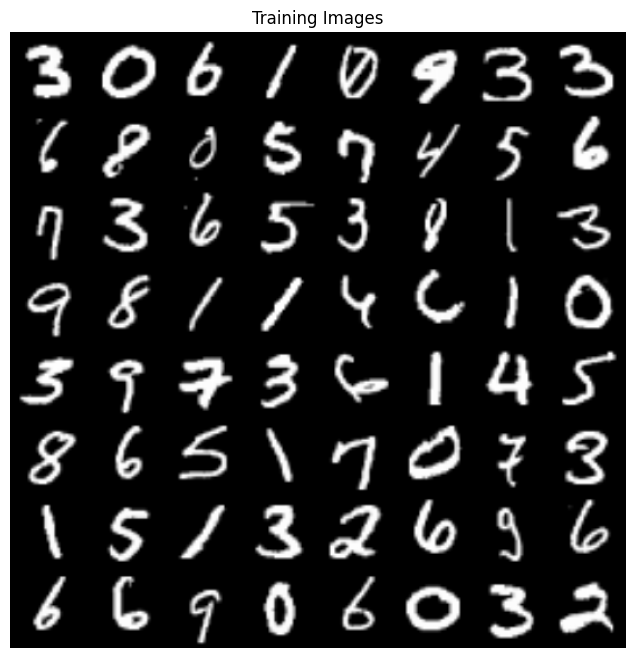

In [6]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# **2-1) GAN**

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(64, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()

        self.linear2 = nn.Linear(512, 16*1024)
        self.batch_norm2 = nn.BatchNorm1d(16*1024)
        self.relu2 = nn.ReLU()

        self.pixel_shuffle1 = nn.PixelShuffle(2)

        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        self.pixel_shuffle2 = nn.PixelShuffle(2)

        self.conv2 = nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = (self.linear1(x))
        x = self.relu1(self.batch_norm1(x))
        x = self.relu2(self.batch_norm2(self.linear2(x)))
        x = x.view(x.size(0), 64, 16, 16)  # Reshape for pixel shuffle
        x = self.pixel_shuffle1(x)
        x = self.conv1(x)
        x = self.relu3(self.batch_norm3(x))
        x = self.pixel_shuffle2(x)
        x = self.conv2(x)
        return torch.tanh(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.linear1 = nn.Linear(16384, 512) #64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()

        self.linear2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten for linear layer
        x = self.relu3(self.linear1(x))
        x = self.linear2(x)
        return torch.sigmoid(x)

In [ ]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (linear1): Linear(in_features=64, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=512, out_features=16384, bias=True)
  (batch_norm2): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pixel_shuffle1): PixelShuffle(upscale_factor=2)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pixel_shuffle2): PixelShuffle(upscale_factor=2)
  (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (linear1): Linear(in_features=16384, out_feat

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list0 = []
img_list1 = []
img_list2 = []
real_list0 = []
real_list1 = []
real_list2 = []
G_losses = []
D_losses = []
iters = 0
EPOCH_NUM = 20

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):
        optimizerD.zero_grad()
        # (1) Update the discriminator with real data
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        noise = torch.randn(b_size, Z_DIM, device=device)
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (3) Update the generator with fake data
        optimizerG.zero_grad()
        netG.zero_grad()
        label.fill_(REAL_LABEL)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if ((epoch == 0) and (i == len(dataloader)-1)): #(iters % 500 == 0) or
            print("hi")
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list0.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == EPOCH_NUM/2) and (i == len(dataloader)-1)):
            print("hi111")
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list1.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == EPOCH_NUM-2) and (i == len(dataloader)-1)):
            print("hi22")
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list2.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/469]	Loss_D: 1.3866	Loss_G: 0.6284	D(x): 0.5048	D(G(z)): 0.5049 / 0.5334
[0/20][50/469]	Loss_D: 0.0661	Loss_G: 6.0236	D(x): 0.9666	D(G(z)): 0.0267 / 0.0260
[0/20][100/469]	Loss_D: 0.1014	Loss_G: 8.3657	D(x): 0.9849	D(G(z)): 0.0563 / 0.0108
[0/20][150/469]	Loss_D: 0.1252	Loss_G: 4.6051	D(x): 0.9569	D(G(z)): 0.0623 / 0.0382
[0/20][200/469]	Loss_D: 0.3321	Loss_G: 2.3013	D(x): 0.8292	D(G(z)): 0.1072 / 0.1493
[0/20][250/469]	Loss_D: 1.3289	Loss_G: 3.1892	D(x): 0.9577	D(G(z)): 0.6454 / 0.0581
[0/20][300/469]	Loss_D: 0.8169	Loss_G: 1.1036	D(x): 0.6150	D(G(z)): 0.2278 / 0.3617
[0/20][350/469]	Loss_D: 1.3438	Loss_G: 0.4369	D(x): 0.3302	D(G(z)): 0.1379 / 0.6654
[0/20][400/469]	Loss_D: 1.0533	Loss_G: 1.2663	D(x): 0.7103	D(G(z)): 0.4948 / 0.2927
[0/20][450/469]	Loss_D: 1.3399	Loss_G: 1.6491	D(x): 0.8258	D(G(z)): 0.6701 / 0.2015
hi
[1/20][0/469]	Loss_D: 1.5909	Loss_G: 1.8415	D(x): 0.8832	D(G(z)): 0.7597 / 0.1652
[1/20][50/469]	Loss_D: 1.0927	Loss_G: 1.4194	D(x): 0

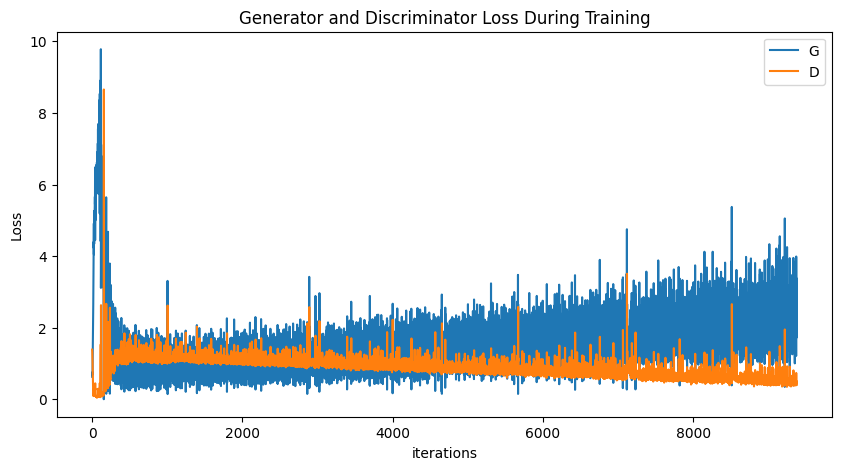

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
def image_grid(array, ncols=10):
    index, channels, height, width = array.shape
    nrows = index//ncols

    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))

    return img_grid

Text(0.5, 1.0, 'level 3 output')

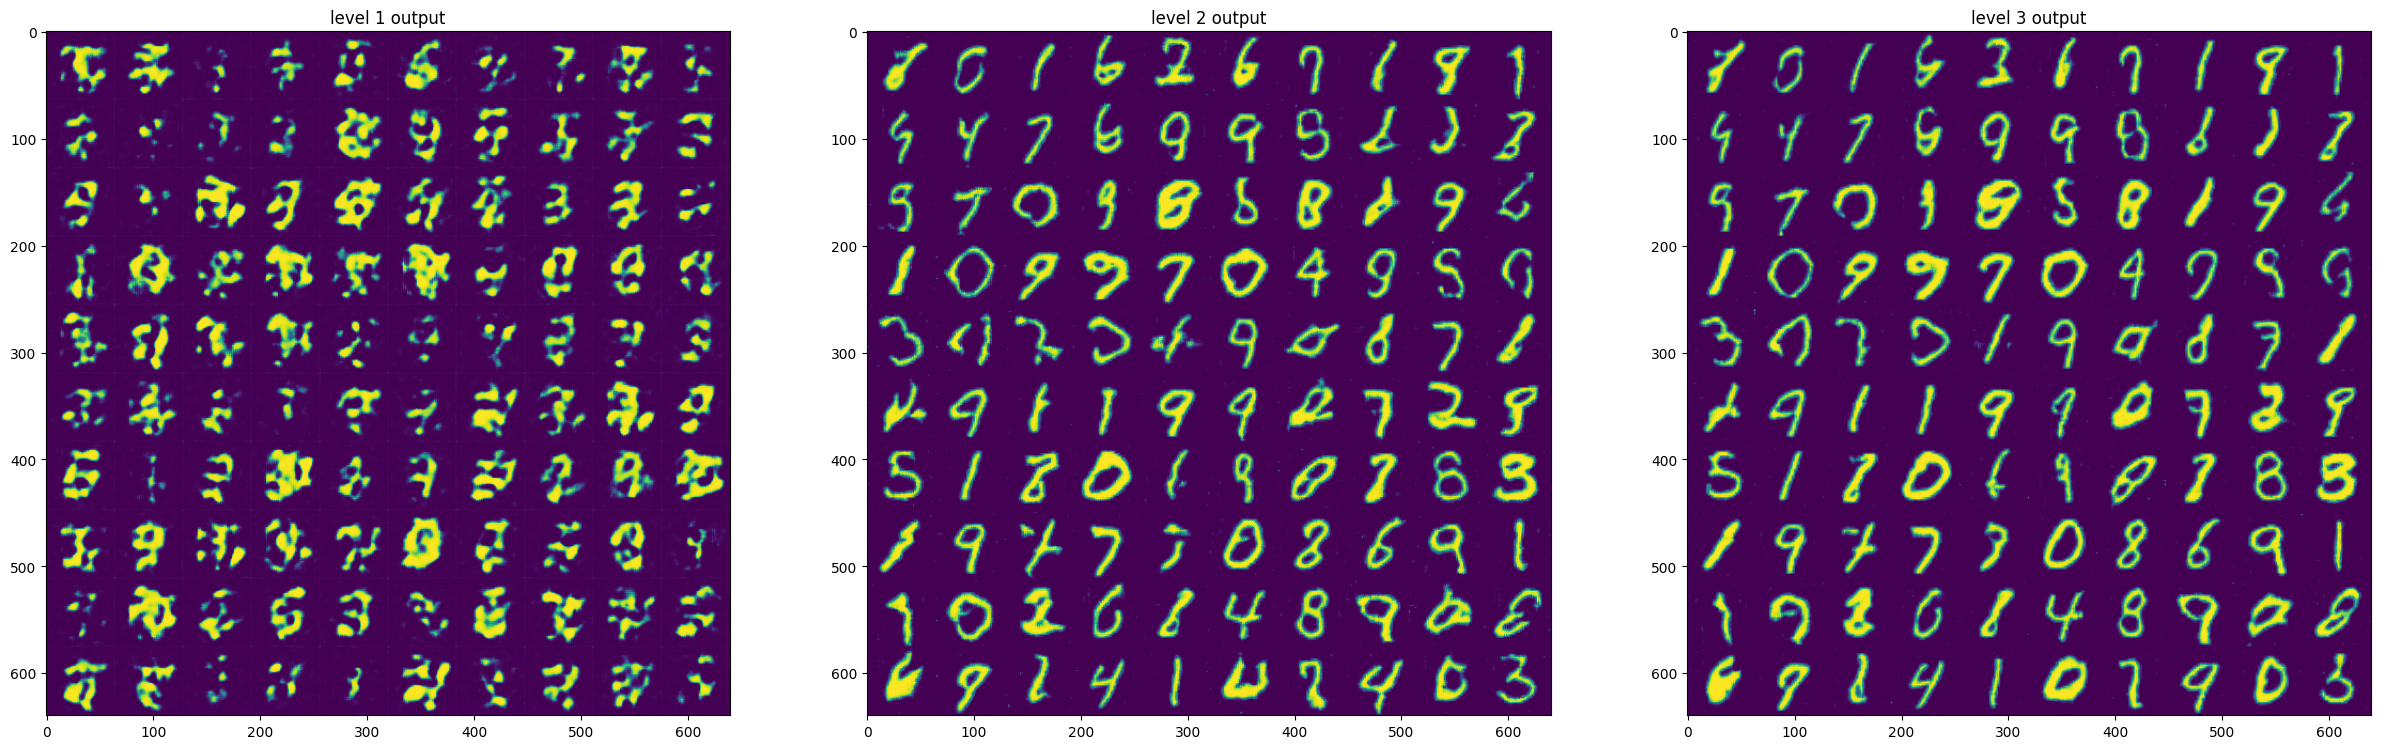

In [ ]:
plt.figure(figsize=(30,30))
tt = np.array(img_list0[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 1)
plt.imshow(Grid)
plt.title('level 1 output')

tt = np.array(img_list1[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 2)
plt.imshow(Grid)
plt.title('level 2 output')

tt = np.array(img_list2[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 3)
plt.imshow(Grid)
plt.title('level 3 output')

In [ ]:
for i, data in enumerate(dataloader, 0):
  real_data = data
  break
real_data = real_data[0:100]
fake_data=img_list2

In [ ]:
!rm -rf aa
!rm -rf bb
!mkdir aa
!mkdir bb

In [ ]:
cnt = 0
for i in fake_data[0]:
  cnt += 1
  result = Image.fromarray((i[0].numpy() * 255).astype(np.uint8))
  result.save('./aa/'+str(cnt)+'.bmp')
cnt = 0
for i in real_data[0]:
  cnt += 1
  result = Image.fromarray((np.array(i[0]) * 255).astype(np.uint8))
  result.save('./bb/'+str(cnt)+'.bmp')

In [ ]:
!python -m pytorch_fid './aa' './bb' --dims 64 --device cuda:0

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 237MB/s]
100% 2/2 [00:00<00:00,  4.65it/s]
100% 3/3 [00:00<00:00, 13.03it/s]
FID:  0.04030948264796841


# **2-2) WGAN Without GP**

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(64, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()

        self.linear2 = nn.Linear(512, 16*1024)
        self.batch_norm2 = nn.BatchNorm1d(16*1024)
        self.relu2 = nn.ReLU()

        self.pixel_shuffle1 = nn.PixelShuffle(2)

        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        self.pixel_shuffle2 = nn.PixelShuffle(2)

        self.conv2 = nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = (self.linear1(x))
        x = self.relu1(self.batch_norm1(x))
        x = self.relu2(self.batch_norm2(self.linear2(x)))
        x = x.view(x.size(0), 64, 16, 16)  # Reshape for pixel shuffle
        x = self.pixel_shuffle1(x)
        x = self.conv1(x)
        x = self.relu3(self.batch_norm3(x))
        x = self.pixel_shuffle2(x)
        x = self.conv2(x)
        return torch.tanh(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.linear1 = nn.Linear(16384, 512) #64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()

        self.linear2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten for linear layer
        x = self.relu3(self.linear1(x))
        x = self.linear2(x)
        return x

In [ ]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 64
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 50
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 5e-5
seed = 1
CRITIC_ITER = 5
WEIGHT_CLIP = 0.01

In [ ]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (linear1): Linear(in_features=64, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=512, out_features=16384, bias=True)
  (batch_norm2): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pixel_shuffle1): PixelShuffle(upscale_factor=2)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pixel_shuffle2): PixelShuffle(upscale_factor=2)
  (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (linear1): Linear(in_features=16384, out_feat

In [ ]:
# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list0 = []
img_list1 = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        real_cpu = data[0].to(device)

        b_size = real_cpu.size(0)

        # Train Discriminator: min -E[Desc(gen_fake)]
        for _ in range(CRITIC_ITER):
          optimizerD.zero_grad()
          noise = torch.randn(b_size, Z_DIM, device=device)
          fake = netG(noise)
          outputr = netD(real_cpu).view(-1)
          errD_real = torch.mean(outputr)
          outputf = netD(fake.detach()).view(-1)
          errD_fake = torch.mean(outputf)

          errD = -(errD_real - errD_fake)
          netD.zero_grad()
          errD.backward(retain_graph=True)
          optimizerD.step()

          for p in netD.parameters():
            p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: min -E[Desc(gen_fake)]
        optimizerG.zero_grad()
        output = netD(fake).view(-1)
        errG = -torch.mean(output)
        netG.zero_grad()
        errG.backward()
        optimizerG.step()


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if ((epoch == 0) and (i == len(dataloader)-1)): #(iters % 500 == 0) or
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list0.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == 25) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list1.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == 49) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list2.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/469]	Loss_D: -0.1033	Loss_G: -0.0120
[0/50][50/469]	Loss_D: -57.9316	Loss_G: -28.3014
[0/50][100/469]	Loss_D: -47.5610	Loss_G: -39.6083
[0/50][150/469]	Loss_D: -38.8623	Loss_G: -47.0906
[0/50][200/469]	Loss_D: -33.3356	Loss_G: -52.4864
[0/50][250/469]	Loss_D: -28.3680	Loss_G: -55.1055
[0/50][300/469]	Loss_D: -24.0934	Loss_G: -58.8449
[0/50][350/469]	Loss_D: -20.2449	Loss_G: -61.7264
[0/50][400/469]	Loss_D: -17.2433	Loss_G: -63.9124
[0/50][450/469]	Loss_D: -14.7364	Loss_G: -65.8598
[1/50][0/469]	Loss_D: -13.9587	Loss_G: -67.0344
[1/50][50/469]	Loss_D: -11.1320	Loss_G: -68.1571
[1/50][100/469]	Loss_D: -9.8080	Loss_G: -68.7037
[1/50][150/469]	Loss_D: -8.3380	Loss_G: -67.3233
[1/50][200/469]	Loss_D: -7.0080	Loss_G: -68.9671
[1/50][250/469]	Loss_D: -7.0365	Loss_G: -73.2276
[1/50][300/469]	Loss_D: -7.5278	Loss_G: -85.3294
[1/50][350/469]	Loss_D: -7.7903	Loss_G: -83.0905
[1/50][400/469]	Loss_D: -7.2579	Loss_G: -72.1411
[1/50][450/469]	Loss_D: -7.0767	Loss_G:

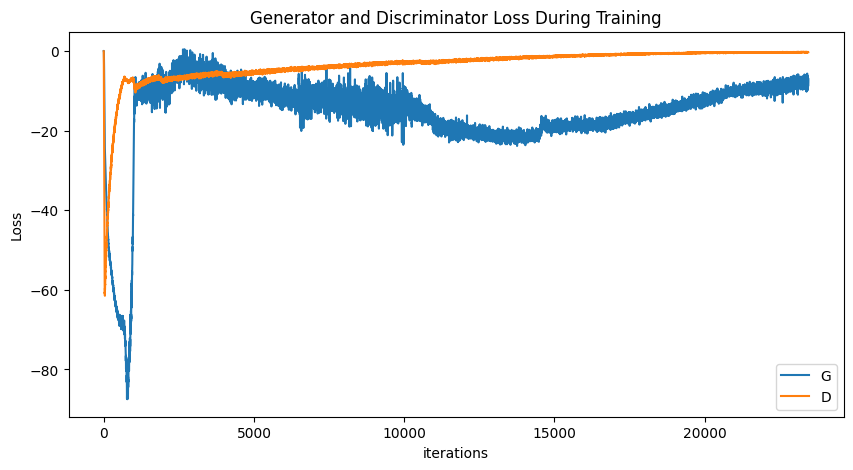

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
len(img_list1)

1

Text(0.5, 1.0, 'level 3 output')

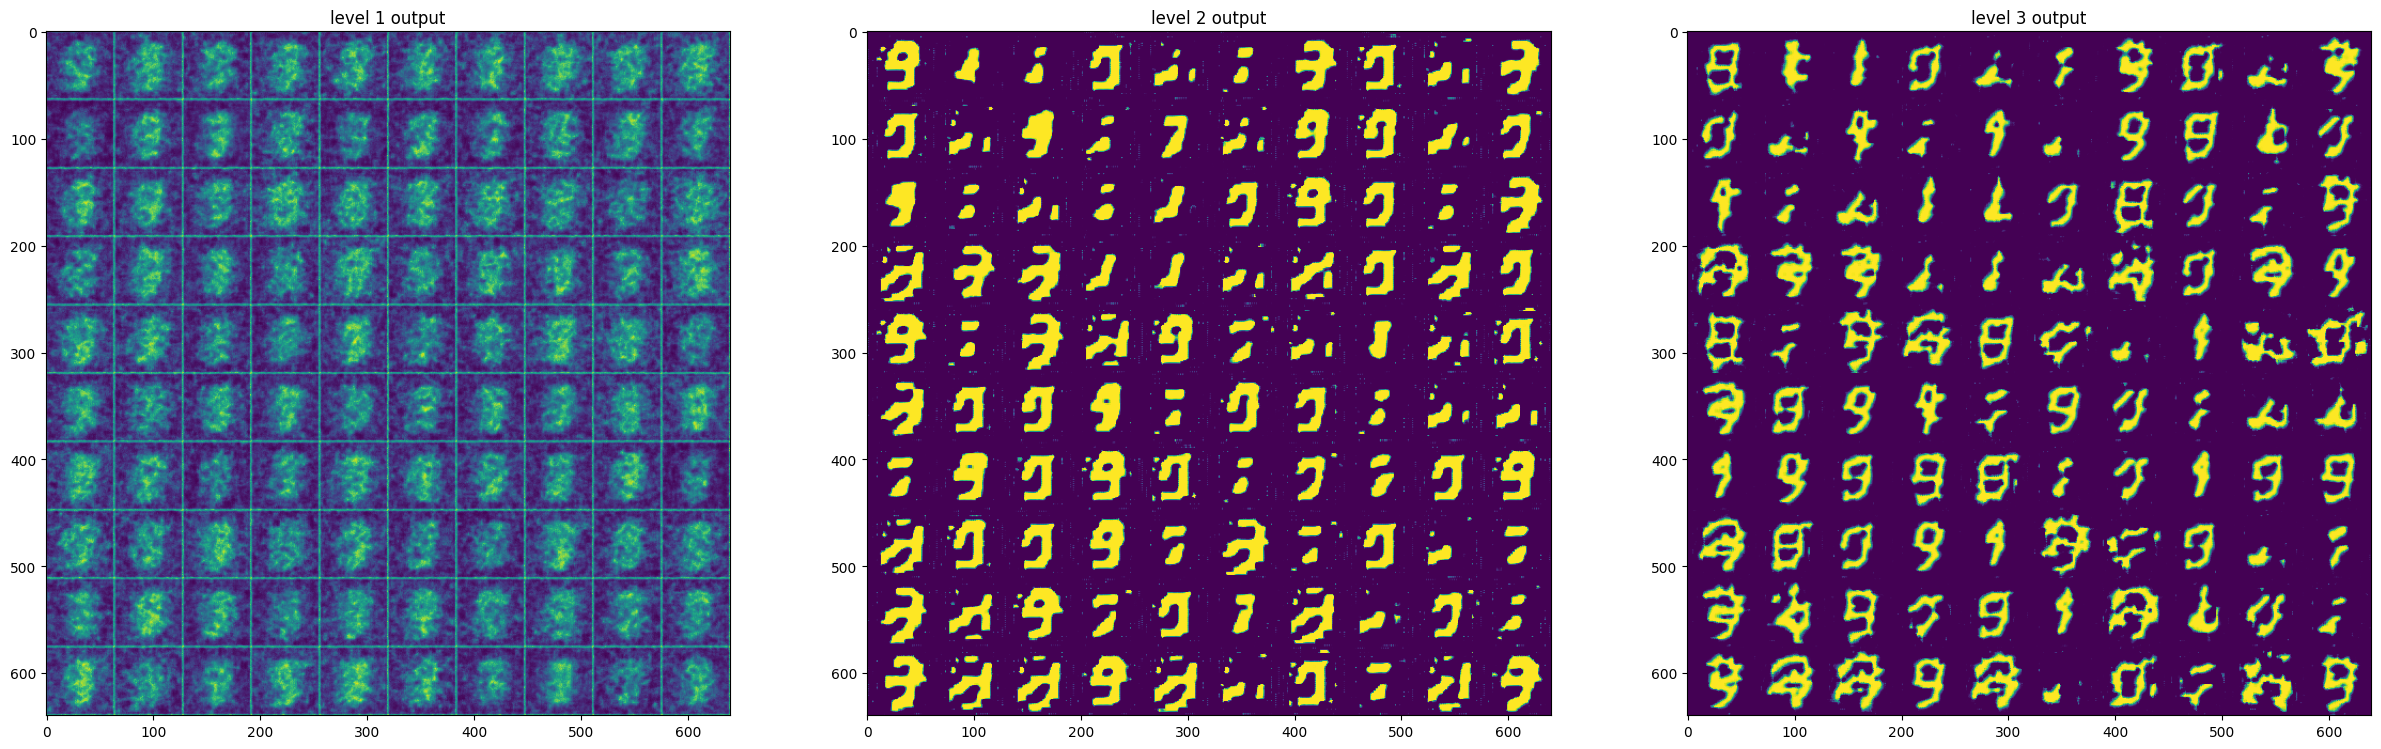

In [ ]:
plt.figure(figsize=(30,30))
tt = np.array(img_list0[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 1)
plt.imshow(Grid)
plt.title('level 1 output')

tt = np.array(img_list1[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 2)
plt.imshow(Grid)
plt.title('level 2 output')

tt = np.array(img_list2[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 3)
plt.imshow(Grid)
plt.title('level 3 output')

In [ ]:
for i, data in enumerate(dataloader, 0):
  real_data = data
  break
real_data = real_data[0:100]
fake_data=img_list2

In [ ]:
!rm -rf aa
!rm -rf bb
!mkdir aa
!mkdir bb

In [ ]:
cnt = 0
for i in fake_data[0]:
  cnt += 1
  result = Image.fromarray((i[0].numpy() * 255).astype(np.uint8))
  result.save('./aa/'+str(cnt)+'.bmp')
cnt = 0
for i in real_data[0]:
  cnt += 1
  result = Image.fromarray((np.array(i[0]) * 255).astype(np.uint8))
  result.save('./bb/'+str(cnt)+'.bmp')

In [ ]:
!python -m pytorch_fid './aa' './bb' --dims 64 --device cuda:0

100% 2/2 [00:00<00:00,  5.05it/s]
100% 3/3 [00:00<00:00, 13.28it/s]
FID:  0.12820436970977478


# **2-2) WGAN With GP**

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(64, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()

        self.linear2 = nn.Linear(512, 16*1024)
        self.batch_norm2 = nn.BatchNorm1d(16*1024)
        self.relu2 = nn.ReLU()

        self.pixel_shuffle1 = nn.PixelShuffle(2)

        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        self.pixel_shuffle2 = nn.PixelShuffle(2)

        self.conv2 = nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = (self.linear1(x))
        x = self.relu1(self.batch_norm1(x))
        x = self.relu2(self.batch_norm2(self.linear2(x)))
        x = x.view(x.size(0), 64, 16, 16)  # Reshape for pixel shuffle
        x = self.pixel_shuffle1(x)
        x = self.conv1(x)
        x = self.relu3(self.batch_norm3(x))
        x = self.pixel_shuffle2(x)
        x = self.conv2(x)
        return torch.tanh(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.linear1 = nn.Linear(16384, 512) #64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()

        self.linear2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten for linear layer
        x = self.relu3(self.linear1(x))
        x = self.linear2(x)
        return x

In [ ]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 64
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 50
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 1e-4
seed = 1
LAMBDA_GP = 10
CRITIC_ITER = 5
WEIGHT_CLIP = 0.01

In [ ]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (linear1): Linear(in_features=64, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=512, out_features=16384, bias=True)
  (batch_norm2): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pixel_shuffle1): PixelShuffle(upscale_factor=2)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pixel_shuffle2): PixelShuffle(upscale_factor=2)
  (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (linear1): Linear(in_features=16384, out_feat

In [ ]:
# def gradient_penaulty(model, real, fake, device):
#   BATCH_SIZE, C, H, W = real[0].shape
#   epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
#   interpolated_imgs = real * epsilon + fake * (1- epsilon)
#   # critic scores:
#   mixed_scores = model(interpolated_imgs)

#   gradients = torch.autograd.grad(
#         outputs=mixed_scores,
#         inputs=interpolated_imgs,
#         grad_outputs=torch.one_like(mixed_scores),
#         create_graph=True,
#         retain_graph=True,
#         only_inputs=True,
#     )[0]

#   gradients = gradients.view(gradients.size(0), -1)
#   gradients_norm = gradients.norm(2, dim=1)
#   gradient_penalty = torch.mean((gradients_norm - 1) ** 2)

#   return gradient_penalty


In [ ]:
def calc_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)
    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [ ]:
# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0, 0.9))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list0 = []
img_list1 = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        real_cpu = data[0].to(device)

        b_size = real_cpu.size(0)

        # Train Discriminator: min -E[Desc(gen_fake)]
        for _ in range(CRITIC_ITER):
          optimizerD.zero_grad()
          noise = torch.randn(b_size, Z_DIM, device=device)
          fake = netG(noise)
          outputr = netD(real_cpu).view(-1)
          errD_real = torch.mean(outputr)
          outputf = netD(fake.detach()).view(-1)
          errD_fake = torch.mean(outputf)

          gp = calc_gradient_penalty(netD, real_cpu, fake.detach(), device=device)
          errD = -(errD_real - errD_fake) + (LAMBDA_GP * gp)
          netD.zero_grad()
          errD.backward(retain_graph=True)
          optimizerD.step()

          # for p in netD.parameters():
          #   p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: min -E[Desc(gen_fake)]
        optimizerG.zero_grad()
        output = netD(fake).view(-1)
        errG = -torch.mean(output)
        netG.zero_grad()
        errG.backward()
        optimizerG.step()


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if ((epoch == 0) and (i == len(dataloader)-1)): #(iters % 500 == 0) or
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list0.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == 25) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list1.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == 49) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list2.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/469]	Loss_D: 9.3652	Loss_G: 0.2613
[0/50][50/469]	Loss_D: -141.6199	Loss_G: 307.7454
[0/50][100/469]	Loss_D: -98.3004	Loss_G: 306.5626
[0/50][150/469]	Loss_D: -81.4130	Loss_G: 236.6612
[0/50][200/469]	Loss_D: -64.0685	Loss_G: 202.1955
[0/50][250/469]	Loss_D: -54.9557	Loss_G: 292.4901
[0/50][300/469]	Loss_D: -51.1439	Loss_G: 325.8296
[0/50][350/469]	Loss_D: -41.7011	Loss_G: 387.8333
[0/50][400/469]	Loss_D: -43.2287	Loss_G: 398.3817
[0/50][450/469]	Loss_D: -39.0780	Loss_G: 462.6013
[1/50][0/469]	Loss_D: -37.6049	Loss_G: 475.4569
[1/50][50/469]	Loss_D: -38.3629	Loss_G: 527.1810
[1/50][100/469]	Loss_D: -35.0339	Loss_G: 569.5156
[1/50][150/469]	Loss_D: -36.6607	Loss_G: 590.2792
[1/50][200/469]	Loss_D: -33.6068	Loss_G: 612.7462
[1/50][250/469]	Loss_D: -31.3363	Loss_G: 629.6797
[1/50][300/469]	Loss_D: -31.6721	Loss_G: 581.8784
[1/50][350/469]	Loss_D: -31.8438	Loss_G: 548.5709
[1/50][400/469]	Loss_D: -32.5400	Loss_G: 581.7819
[1/50][450/469]	Loss_D: -34.7025	

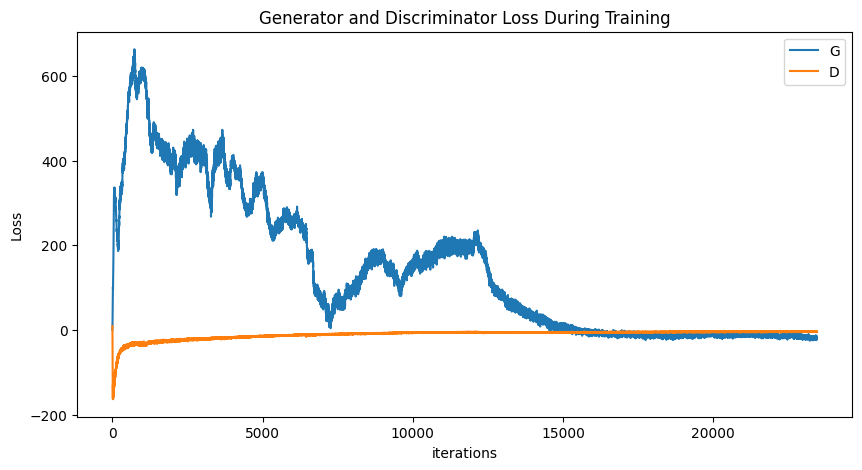

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
len(img_list1)

1

Text(0.5, 1.0, 'level 3 output')

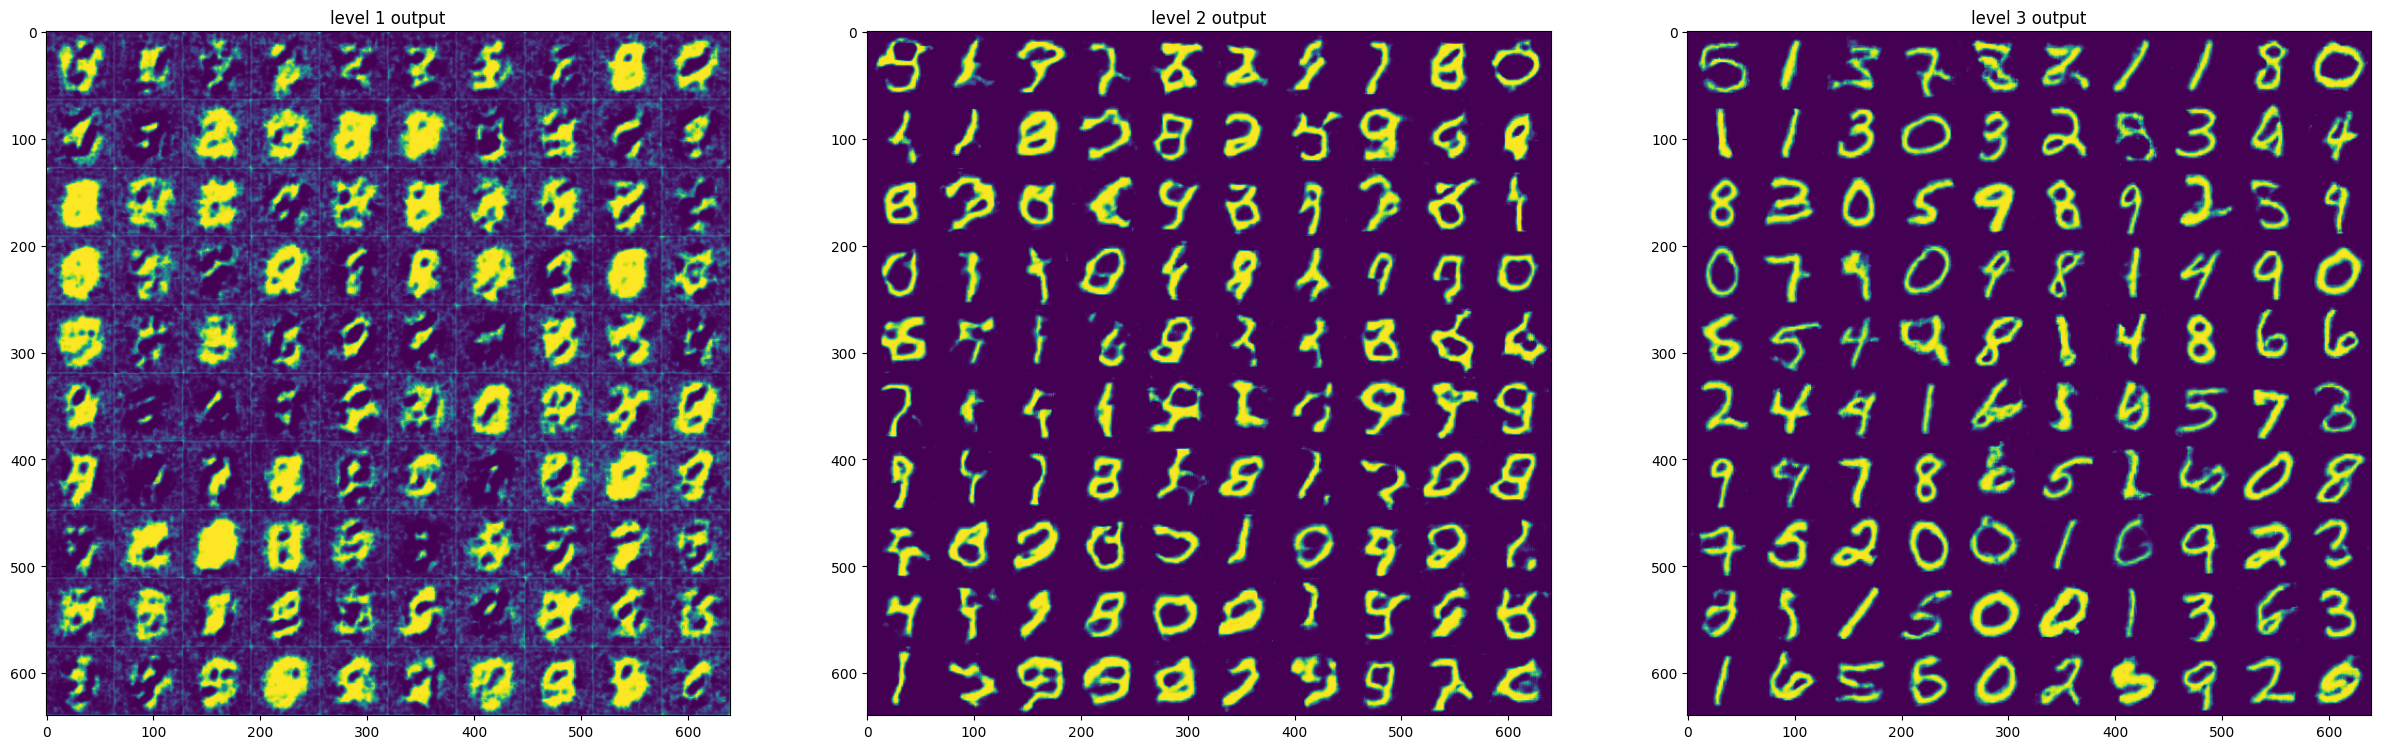

In [ ]:
plt.figure(figsize=(30,30))
tt = np.array(img_list0[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 1)
plt.imshow(Grid)
plt.title('level 1 output')

tt = np.array(img_list1[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 2)
plt.imshow(Grid)
plt.title('level 2 output')

tt = np.array(img_list2[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 3)
plt.imshow(Grid)
plt.title('level 3 output')

In [ ]:
for i, data in enumerate(dataloader, 0):
  real_data = data
  break
real_data = real_data[0:100]
fake_data=img_list2

In [ ]:
!rm -rf aa
!rm -rf bb
!mkdir aa
!mkdir bb

In [ ]:
cnt = 0
for i in fake_data[0]:
  cnt += 1
  result = Image.fromarray((i[0].numpy() * 255).astype(np.uint8))
  result.save('./aa/'+str(cnt)+'.bmp')
cnt = 0
for i in real_data[0]:
  cnt += 1
  result = Image.fromarray((np.array(i[0]) * 255).astype(np.uint8))
  result.save('./bb/'+str(cnt)+'.bmp')

In [ ]:
!python -m pytorch_fid './aa' './bb' --dims 64 --device cuda:0

100% 2/2 [00:00<00:00,  4.96it/s]
100% 3/3 [00:00<00:00, 13.57it/s]
FID:  0.05171978627938789


# **2-3) SSGAN**

In [9]:
class GeneratorResidual(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GeneratorResidual, self).__init__()

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.batch_norm2= nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        x2 = self.batch_norm1(x)
        x2 = self.relu1(x2)
        x2 = self.upsample1(x2)
        x2 = self.conv1(x2)
        x2 = self.batch_norm2(x2)
        x2 = self.relu2(x2)
        x2 = self.conv2(x2)
        x3 = self.upsample2(x)

        return x2 + x3

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(128, 256*4*4)
        self.residual1 = GeneratorResidual(256, 256)
        self.residual2 = GeneratorResidual(256, 256)
        self.residual3 = GeneratorResidual(256, 256)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.linear1(x)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.relu1(x)
        x = self.conv1(x)

        return torch.tanh(x)

In [11]:
class DiscriminatorResidual(nn.Module):
    def __init__(self, in_channels, out_channels, first_relu=True, down_sample=False):
        super(DiscriminatorResidual, self).__init__()

        self.first_relu = first_relu
        self.downsample = down_sample

        self.relu1 = nn.ReLU()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
        self.relu2 = nn.ReLU()
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.relu3 = nn.ReLU()

        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x2 = x
        if (self.first_relu == True):
          x2 = self.relu1(x2)
        x2 = self.conv1(x2)
        x2 = self.relu2(x2)
        x2 = self.conv2(x2)
        if (self.downsample == True):
          x2 = self.avgpool1(x2)
        if (self.first_relu == True):
          x2 = self.relu3(x2)

        x3 = x
        if (self.downsample == True):
          x3 = self.avgpool2(x)
        x3 = self.conv3(x3)

        return x2 + x3

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.residual1 = DiscriminatorResidual(1, 128, first_relu=False, down_sample=True)
        self.residual2 = DiscriminatorResidual(128, 128, down_sample=True)
        self.residual3 = DiscriminatorResidual(128, 128)
        self.residual4 = DiscriminatorResidual(128, 128)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(128, 1)
        self.linear2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        x = self.relu1(x)
        x = torch.sum(x,dim = (2,3))
        x2 = self.linear1(x)
        x3 = self.linear2(x)
        return x2, x3

In [13]:
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 128
G_HIDDEN = 64
X_DIM = 32
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1
LAMBDA_GP = 10
CRITIC_ITER = 5

In [14]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [15]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (linear1): Linear(in_features=128, out_features=4096, bias=True)
  (residual1): GeneratorResidual(
    (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (upsample1): Upsample(scale_factor=2.0, mode='nearest')
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample2): Upsample(scale_factor=2.0, mode='nearest')
  )
  (residual2): GeneratorResidual(
    (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (upsample1): Upsample(scale_factor=2.0, mode='nearest')
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [16]:
def calc_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)
    model_interpolates, _ = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [17]:
# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.9, 0.99))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.9, 0.99))

In [18]:
def rotation_transform(data):
  x = data
  x_90 = x.transpose(2,3)
  x_180 = x.flip(2,3)
  x_270 = x.transpose(2,3).flip(2,3)
  data = torch.cat((x,x_90,x_180,x_270),0)
  return data

In [19]:
# Training Loop

# Lists to keep track of progress
img_list0 = []
img_list1 = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # make rotations for real data
        rotated_data_real = rotation_transform(real_cpu)

        # Add auxilary rotation loss
        rot_labels = torch.zeros(4*b_size).to(device)
        for j in range(b_size):
            if j < b_size:
                rot_labels[j] = 0
            elif j < 2*b_size:
                rot_labels[j] = 1
            elif j < 3*b_size:
                rot_labels[j] = 2
            else:
                rot_labels[j] = 3
        rot_labels = nn.functional.one_hot(rot_labels.to(torch.int64), 4).float()

        # Train Discriminator: min -E[Desc(gen_fake)]
        for _ in range(CRITIC_ITER):
            optimizerD.zero_grad()
            # fake/true classification
            noise = torch.randn(b_size, Z_DIM, device=device)
            fake = netG(noise)
            # make rotations for fake data
            rotated_data_fake = rotation_transform(fake.detach())

            outputr, _ = netD(rotated_data_real)
            outputr = outputr.view(-1)
            outputf, _ = netD(rotated_data_fake)
            outputf = outputf.view(-1)
            errD_real = torch.mean(outputr)
            errD_fake = torch.mean(outputf)
            gp = calc_gradient_penalty(netD, rotated_data_real, rotated_data_fake, device=device)
            errD = -(errD_real - errD_fake) + (LAMBDA_GP * gp)
            # rotation classification

            _, rotr = netD(rotated_data_real)
            err_rot_real = torch.mean(nn.functional.binary_cross_entropy_with_logits(input = rotr, target = rot_labels))

            netD.zero_grad()
            errD += 1.0 * (err_rot_real)
            errD.backward(retain_graph=True)
            optimizerD.step()

        # Train Generator: min -E[Desc(gen_fake)]
        optimizerG.zero_grad()
        output, rotf = netD(rotated_data_fake)
        output = output.view(-1)
        errG = -torch.mean(output)
        err_rot_fake = torch.mean(nn.functional.binary_cross_entropy_with_logits(input = rotf, target = rot_labels))
        errG += 0.5*err_rot_fake
        netG.zero_grad()
        errG.backward()
        optimizerG.step()


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if ((epoch == 0) and (i == len(dataloader)-1)): #(iters % 500 == 0) or
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list0.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == 2) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list1.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        if ((epoch == 4) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake =netG(viz_noise).detach().cpu()
            img_list2.append(fake[0:100]) #vutils.make_grid(fake[0:100], padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 4.6032	Loss_G: -49.2586
[0/5][50/469]	Loss_D: -27.9902	Loss_G: -463.9163
[0/5][100/469]	Loss_D: -27.1374	Loss_G: -622.4841
[0/5][150/469]	Loss_D: -28.8622	Loss_G: -461.0728
[0/5][200/469]	Loss_D: -29.6639	Loss_G: -696.5347
[0/5][250/469]	Loss_D: -30.9298	Loss_G: -630.7468
[0/5][300/469]	Loss_D: -29.8953	Loss_G: -433.2998
[0/5][350/469]	Loss_D: -30.5521	Loss_G: -307.0259
[0/5][400/469]	Loss_D: -30.2149	Loss_G: -375.2013
[0/5][450/469]	Loss_D: -31.1858	Loss_G: -323.4375
[1/5][0/469]	Loss_D: -30.8931	Loss_G: -307.9586
[1/5][50/469]	Loss_D: -30.7367	Loss_G: -294.6021
[1/5][100/469]	Loss_D: -31.5472	Loss_G: -345.2345
[1/5][150/469]	Loss_D: -31.9078	Loss_G: -255.3165
[1/5][200/469]	Loss_D: -32.9615	Loss_G: -308.2485
[1/5][250/469]	Loss_D: -33.4503	Loss_G: -258.7786
[1/5][300/469]	Loss_D: -33.1241	Loss_G: -262.6143
[1/5][350/469]	Loss_D: -33.5555	Loss_G: -269.2041
[1/5][400/469]	Loss_D: -33.3237	Loss_G: -252.1104
[1/5][450/469]	Loss_D: -31.4919	L

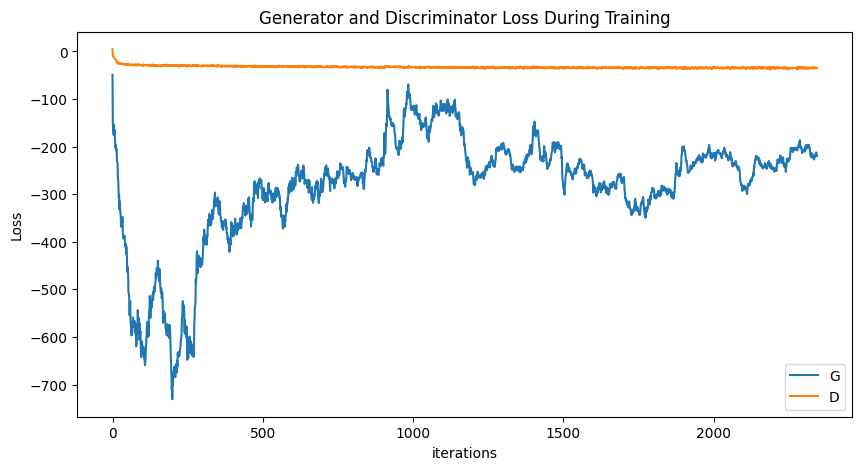

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
len(img_list1)

1

Text(0.5, 1.0, 'level 3 output')

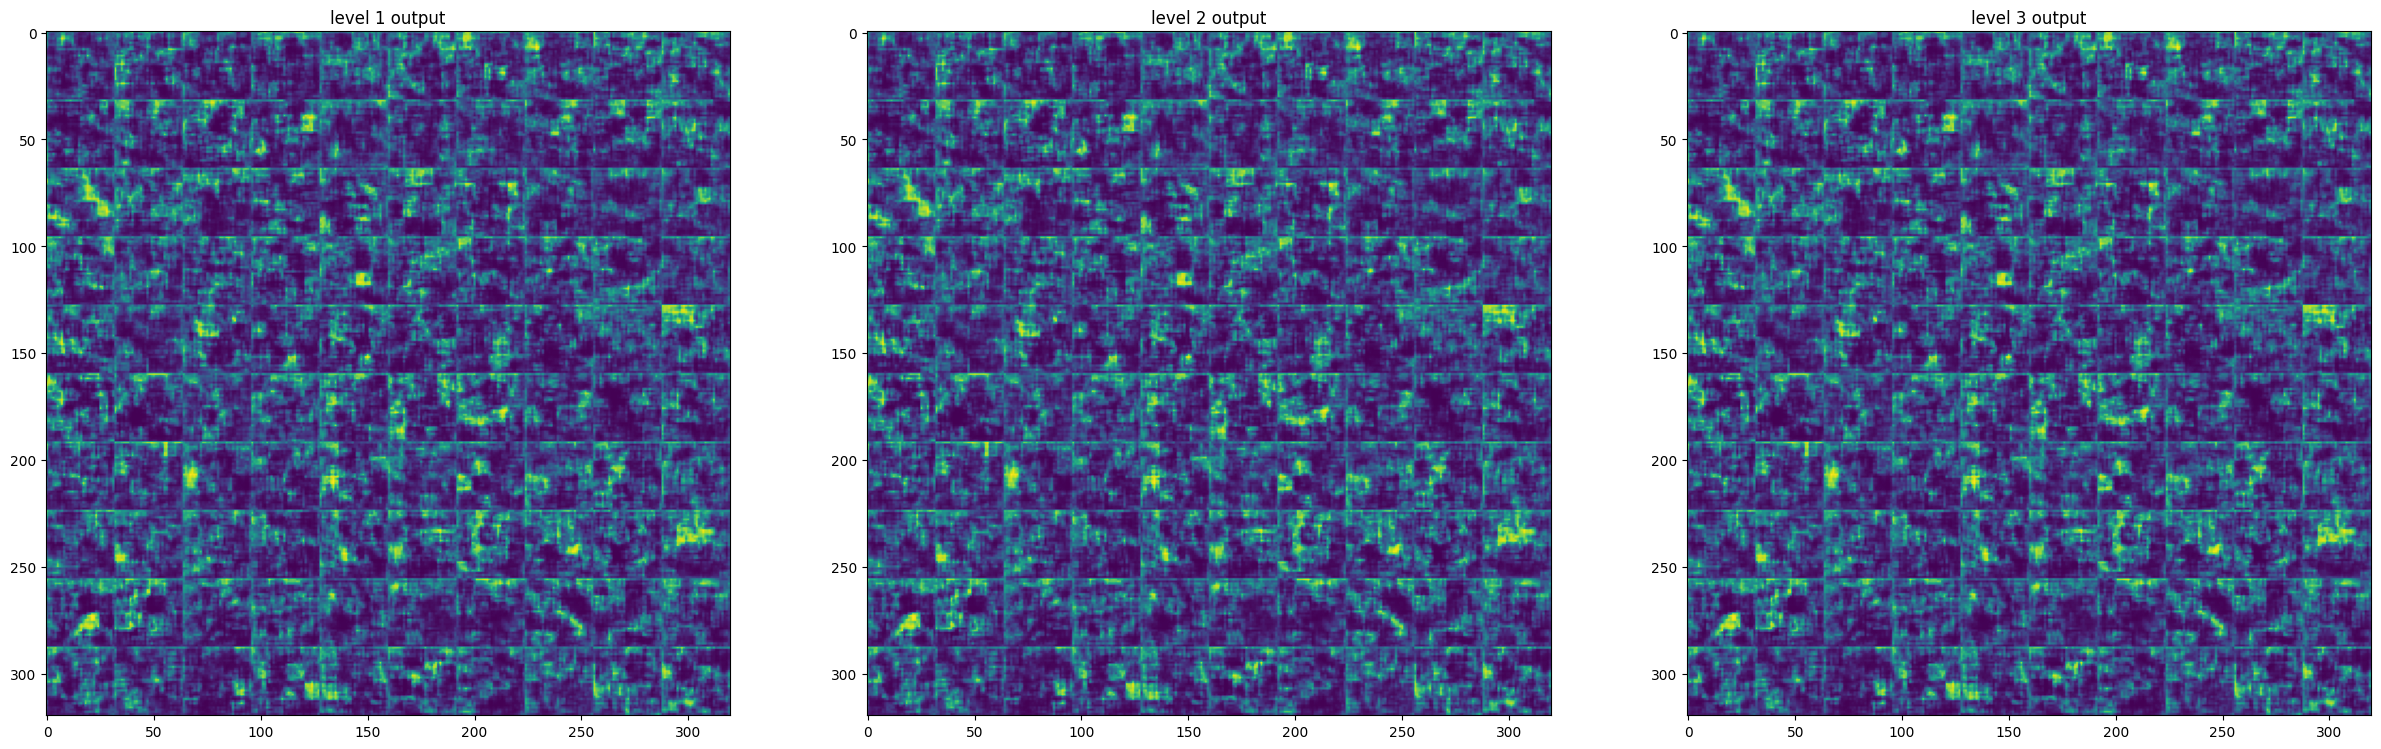

In [22]:
plt.figure(figsize=(30,30))
tt = np.array(img_list0[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 1)
plt.imshow(Grid)
plt.title('level 1 output')

tt = np.array(img_list1[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 2)
plt.imshow(Grid)
plt.title('level 2 output')

tt = np.array(img_list2[0])
Grid = image_grid(tt, ncols=10)
plt.subplot(1, 3, 3)
plt.imshow(Grid)
plt.title('level 3 output')

In [23]:
for i, data in enumerate(dataloader, 0):
  real_data = data
  break
real_data = real_data[0:100]
fake_data=img_list2

In [32]:
!rm -rf aa
!rm -rf bb
!mkdir aa
!mkdir bb

In [33]:
cnt = 0
for i in fake_data[0]:
  cnt += 1
  result = Image.fromarray((i[0].numpy() * 255).astype(np.uint8))
  result.save('./aa/'+str(cnt)+'.bmp')
cnt = 0
for i in real_data[0]:
  cnt += 1
  result = Image.fromarray((np.array(i[0]) * 255).astype(np.uint8))
  result.save('./bb/'+str(cnt)+'.bmp')

In [35]:
!python -m pytorch_fid './aa' './bb' --dims 64 --device cpu

100% 2/2 [00:05<00:00,  2.95s/it]
100% 3/3 [00:08<00:00,  2.70s/it]
FID:  11.43340842888831
